# Trabalhando com previsões em séries temporais

## Bibliotecas comuns

In [139]:
# !pip install seaborn==0.11.1
# !pip install statsmodels==v0.11.0rc2

import pandas as pd
import seaborn as sns
import statsmodels as sm
import numpy as np

sns.set_theme(style="darkgrid")
sns.set(rc={"figure.figsize": (11.7, 8.27)})


## Explorando os dados

In [3]:
df_co2 = pd.read_csv("databases/co2.csv", sep="\t")
df_co2

,data,media
0,1980.042,338.45
1,1980.125,339.15
2,1980.208,339.48
3,1980.292,339.87
4,1980.375,340.30
...,...,...
472,2019.375,411.16
473,2019.458,410.35
474,2019.542,408.69
475,2019.625,407.43


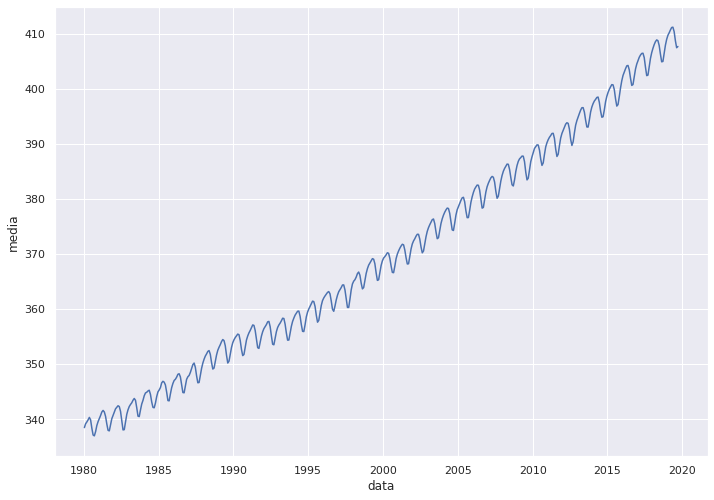

In [15]:
ax = sns.lineplot(x="data", y="media", data=df_co2)

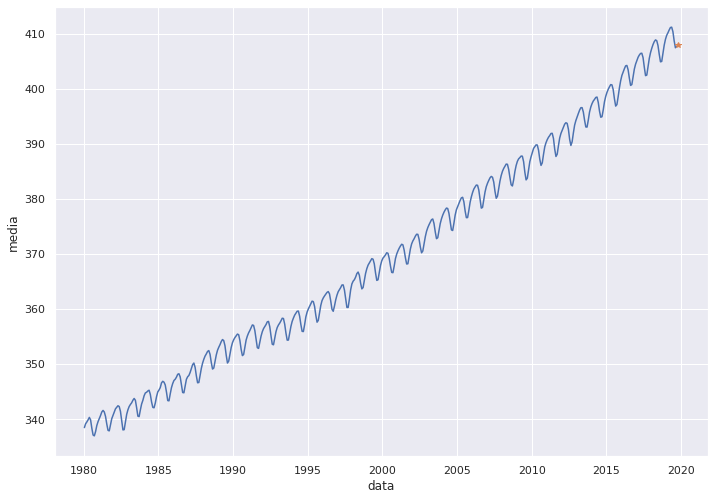

In [43]:
# Tentando gerar a próxima estimativa através da média dos N ultimos registros
N = 3

next_y = df_co2.tail(N)["media"].mean()

shape = df_co2.shape[0]
next_x = df_co2["data"][shape - 1] + (df_co2["data"][shape - 1] - df_co2["data"][shape - 2])


ax = sns.lineplot(x="data", y="media", data=df_co2)
ax = ax.plot(next_x, next_y, "*")


## Tratamento dos dados

In [57]:
# Calculando a média móvel com agrupamento de N em N
N = 5
media_movel_co2 = df_co2.rolling(N).mean()

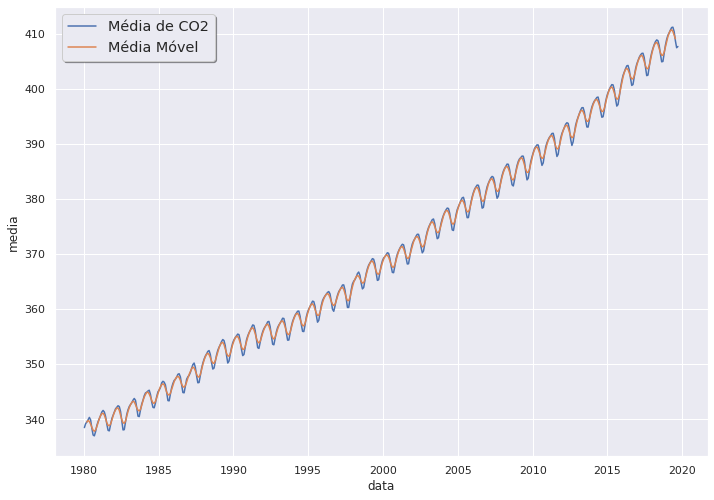

In [58]:
ax = sns.lineplot(x="data", y="media", data=df_co2, label="Média de CO2")
ax.plot(media_movel_co2["data"], media_movel_co2["media"], label="Média Móvel")

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

In [63]:
from statsmodels.tsa.seasonal import seasonal_decompose

P = 35 # dias
decompose = seasonal_decompose(df_co2.set_index("data"), period=P)

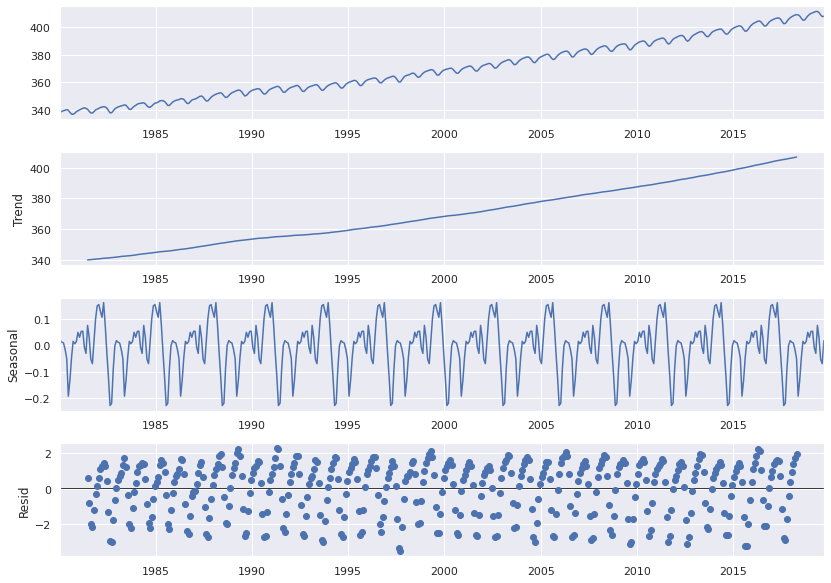

In [65]:
# O ; indica que deve plotar apenas um grupo de gráficos, caso não coloque ele gera dois grupos iguais
decompose.plot();

### Verificando se a série é estacionária

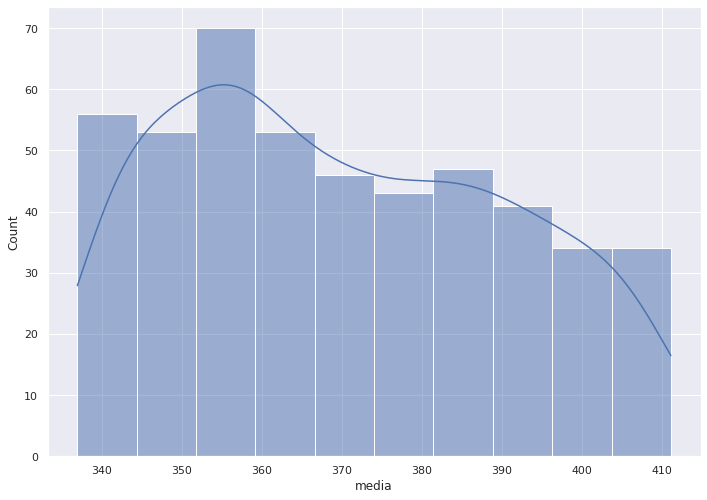

In [67]:
ax = sns.histplot(data=df_co2, x="media", kde=True)

- Um indicativo de não estacionariedade pode ser observado acima. O seu comportamento não é a de uma distribuição normal em formato de sino

In [85]:
half = int(df_co2.shape[0] / 2)
values = df_co2["media"].values

first_half, second_half = values[0:half], values[half:]

In [86]:
# Calculando a variação da média
media_first = first_half.mean()
media_second = second_half.mean()

print(f"Média 1º Metade: {media_first}\nMédia 2º Metade: {media_second}")

Média 1º Metade: 352.31550420168065
Média 2º Metade: 387.816359832636


- Existe uma pequena variação da média, mais um ponto que indica a não estacionaridade

In [87]:
# Calculando a variação
var_first = first_half.var()
var_second = second_half.var()

print(f"Var 1º Metade: {var_first}\nVar 2º Metade: {var_second}")

Var 1º Metade: 73.90219533401597
Var 2º Metade: 151.542490933282


- Existe uma grande variação na série, o que indica a não estacionariedade da mesma

### Teste ADF (Verificar a estacionariedade da série)

In [88]:
from statsmodels.tsa.stattools import adfuller

In [92]:
resultado = adfuller(df_co2["media"].values)

# Quanto mais negativo mais estacionária é a série
print(f"Estatistica ADF: {resultado[0]}")
print(f"P-Value: {resultado[1]}")

Estatistica ADF: 3.036828829166984
P-Value: 1.0


- Neste teste obtivemos um valor positivo para o ADF, o que infere que a série não é estacionária
- P-Value <= 0.05 indica que a série é estacionária

## Diferenciação da série temporal

In [95]:
df_co2["diff"] = df_co2["media"].diff()
df_co2

,data,media,diff
0,1980.042,338.45,NaN
1,1980.125,339.15,0.70
2,1980.208,339.48,0.33
3,1980.292,339.87,0.39
4,1980.375,340.30,0.43
...,...,...,...
472,2019.375,411.16,0.06
473,2019.458,410.35,-0.81
474,2019.542,408.69,-1.66
475,2019.625,407.43,-1.26


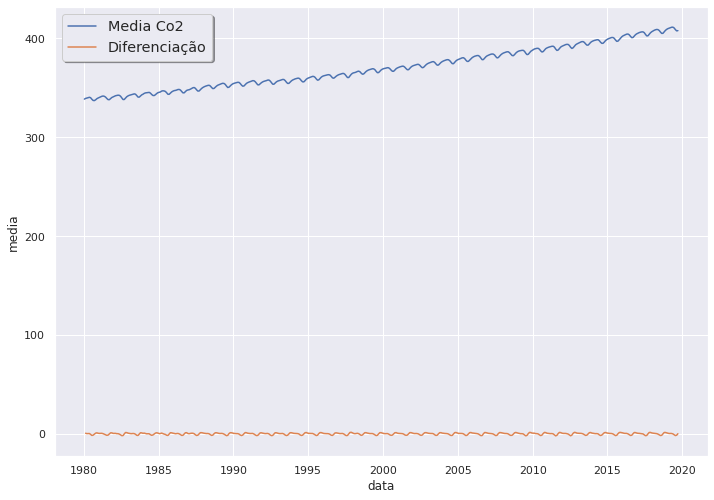

In [96]:
ax = sns.lineplot(x="data", y="media", data=df_co2, label="Media Co2")

ax.plot(df_co2["data"], df_co2["diff"], label="Diferenciação")

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

## Treinamento do Modelo

### Método de Suavização Exponencial

In [98]:
df_train = df_co2[["data", "media"]].set_index("data")
df_train

,media
data,
1980.042,338.45
1980.125,339.15
1980.208,339.48
1980.292,339.87
1980.375,340.30
...,...
2019.375,411.16
2019.458,410.35
2019.542,408.69


In [101]:
train = df_train[1980.042:2015]
test = df_train[2015:]

In [102]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [143]:
model_smoothing = SimpleExpSmoothing(train).fit(smoothing_level=0.5)

/home/davidm/miniconda3/envs/data/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [144]:
predict_smoothing = model_smoothing.forecast(test.shape[0])

/home/davidm/miniconda3/envs/data/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


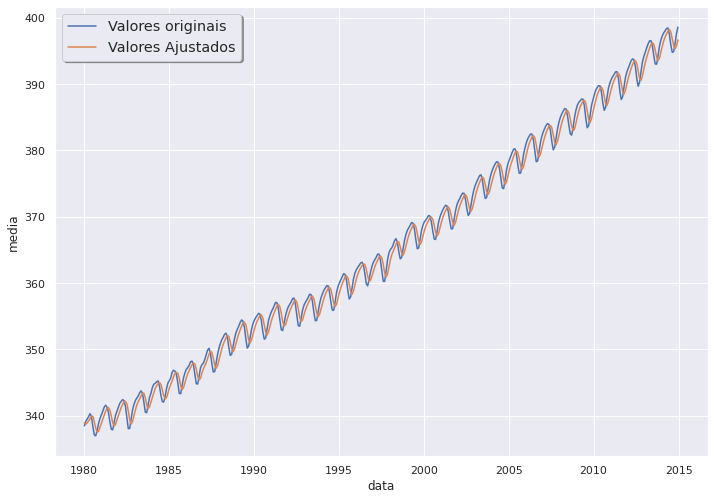

In [145]:
ax = sns.lineplot(x="data", y="media", data=train, label="Valores originais")
ax.plot(train.index, model_smoothing.fittedvalues.values, label="Valores Ajustados")

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

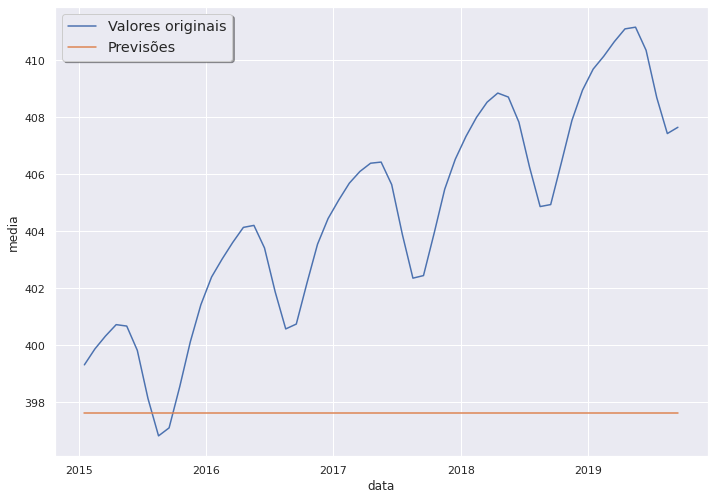

In [146]:
ax = sns.lineplot(x="data", y="media", data=test, label="Valores originais")
ax.plot(test.index, predict_smoothing, label="Previsões")

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

### Método Holt-Winters

- Suavização exponencial de terceira ordem

- Modelo Aditivo:
`Y_t = Nível + Tendência + Sazonalidade + Ruído`

- Modelo Multiplicativo:
`Y_t = Nível * Tendência * Sazonalidade * Ruído`


#### Tendência Aditiva

`E_(t + k) = N_t + k(T_t)

In [116]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [147]:
period = 35

model_hw = ExponentialSmoothing(
    train.values,
    trend="additive",
    seasonal="additive",
    seasonal_periods=period
).fit()

/home/davidm/miniconda3/envs/data/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:735: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [123]:
tr_s = train.shape[0]
te_s = test.shape[0]
print(f"Pontos no banco de treino: {tr_s}\nPontos no banco de testes: {te_s}")

start = tr_s
end = start + te_s - 1

print(f"\nIntervalo de predição: ({start}, {end})")

Pontos no banco de treino: 420
Pontos no banco de testes: 57

Intervalo de predição: (420, 476)


In [148]:
predict_hw = model_hw.predict(start=start, end=end)

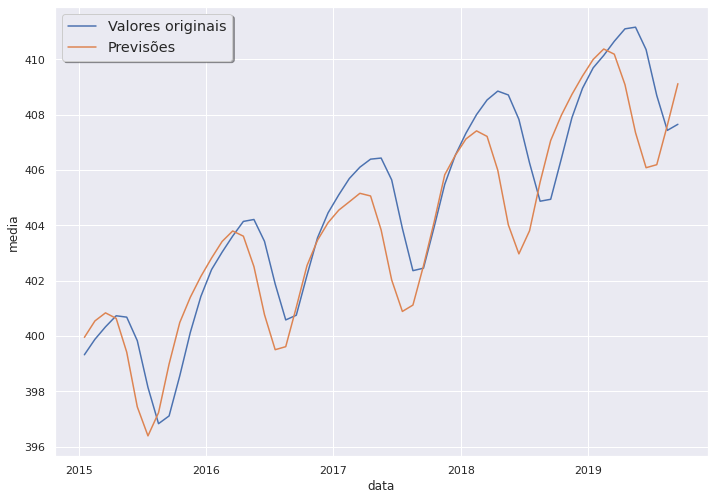

In [149]:
ax = sns.lineplot(x=test.index, y="media", data=test, label="Valores originais")
ax.plot(test.index, predict_hw, label="Previsões")

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

## Correlação e Autocorrelação

- Identificando sazonalidade

In [130]:
from statsmodels.graphics.tsaplots import plot_acf

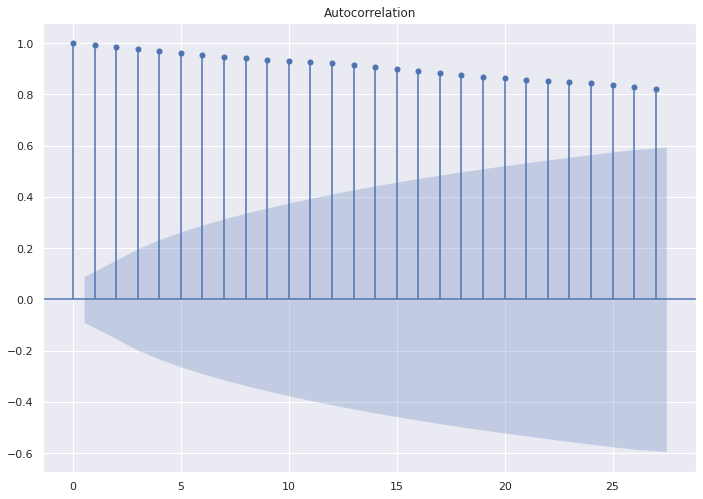

In [132]:
plot_acf(df_co2["media"]);

O cone azul indica uma região de confiança para todos os registros que estão fora do mesmo. Ou seja, estar fora do cone azul indica que a autocorrelação encontrada está atrelada a sazonalidade e não à ruídos.

### Autocorrelação parcial

In [133]:
from statsmodels.graphics.tsaplots import plot_pacf

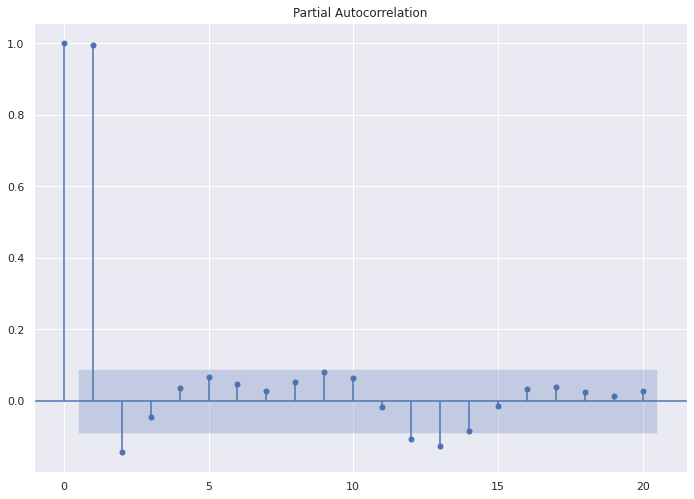

In [135]:
plot_pacf(df_co2["media"], lags=20);

In [136]:
from statsmodels.tsa.ar_model import AutoReg

In [150]:
lags_list = np.linspace(1, 40, 40)
period = 35

model_ar = AutoReg(train.values, lags=lags_list, trend="c", seasonal=True, period=period).fit()

In [151]:
predict_ar = model.predict(start=start, end=end)

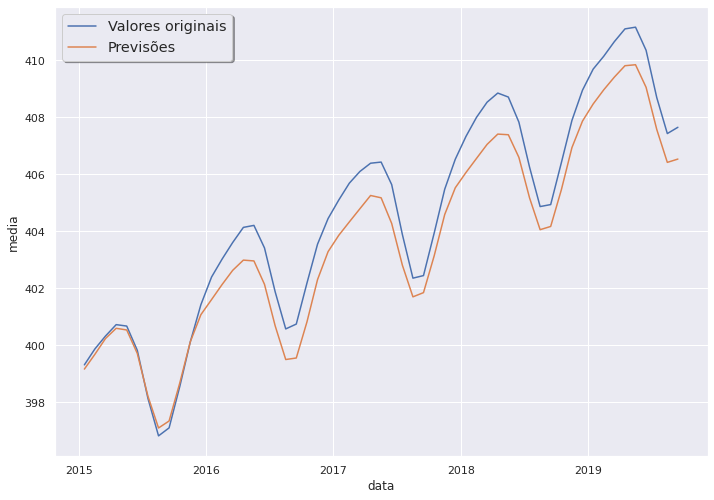

In [152]:
ax = sns.lineplot(x=test.index, y="media", data=test, label="Valores originais")
ax.plot(test.index, predict_ar, label="Previsões")

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

## Verificando o desempenho

- ExpSmoothing x Holt-Winters x Autoregressivo

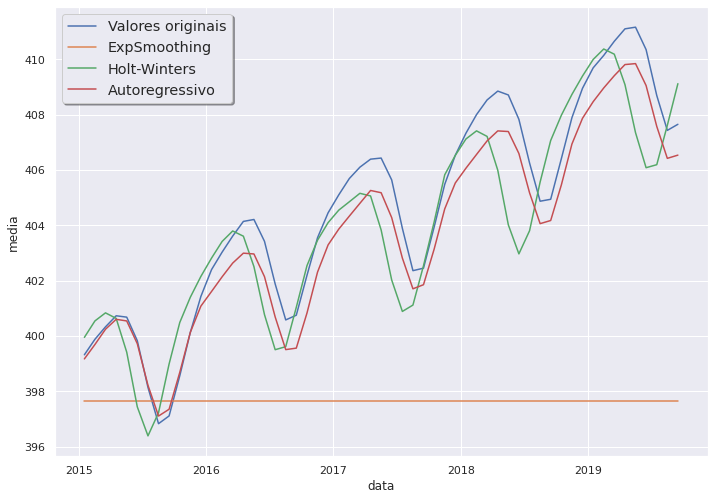

In [153]:
ax = sns.lineplot(x=test.index, y="media", data=test, label="Valores originais")
ax.plot(test.index, predict_smoothing, label="ExpSmoothing")
ax.plot(test.index, predict_hw, label="Holt-Winters")
ax.plot(test.index, predict_ar, label="Autoregressivo")

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

In [172]:
error_pred_smoothing = test["media"] - np.array(predict_smoothing)
error_pred_hw = test["media"] - predict_hw
error_pred_ar = test["media"] - predict_ar

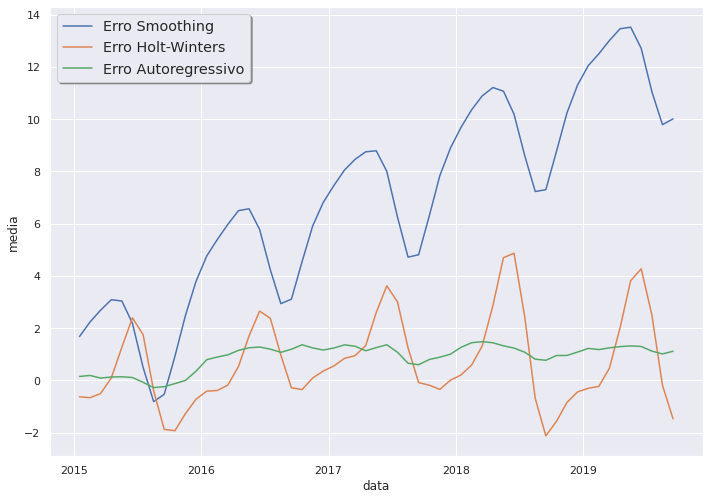

In [173]:
ax = sns.lineplot(x=test.index, y=error_pred_smoothing, label="Erro Smoothing")
ax.plot(test.index, error_pred_hw, label="Erro Holt-Winters")
ax.plot(test.index, error_pred_ar, label="Erro Autoregressivo")

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

In [174]:
mean_error_smoothing = np.mean(error_pred_smoothing).round(3)
mean_error_hw = np.mean(error_pred_hw).round(3)
mean_error_ar = np.mean(error_pred_ar).round(3)

print(f"Erro Médio Smoothing: {mean_error_smoothing}")
print(f"Erro Médio Holt-Winters: {mean_error_hw}")
print(f"Erro Médio Autoregressivo: {mean_error_ar}")

Erro Médio Smoothing: 6.963
Erro Médio Holt-Winters: 0.706
Erro Médio Autoregressivo: 0.899


In [175]:
from sklearn.metrics import mean_absolute_error

# Podemos calcular também através das metricas do sklearn

In [176]:
mae_smoothing = mean_absolute_error(test["media"], predict_smoothing)
mae_hw = mean_absolute_error(test["media"], predict_hw)
mae_ar = mean_absolute_error(test["media"], predict_ar)

print(f"Erro Médio Abs Smoothing: {mae_smoothing}")
print(f"Erro Médio Abs Holt-Winters: {mae_hw}")
print(f"Erro Médio Abs Autoregressivo: {mae_ar}")

Erro Médio Abs Smoothing: 7.010379588569809
Erro Médio Abs Holt-Winters: 1.3409967273657315
Erro Médio Abs Autoregressivo: 0.9245217894116352
